In [1]:
# program to simulate the schelling model in some special cases of the paper of physical analogues
# only the last cell of code has to be changed for the code to work
# instructions on how to choose parameters in the function description of the cell before the last

In [2]:
# importation of libraries
import numpy as np
import random as rnd
import matplotlib.pyplot as plt

In [3]:
# functions to choose the initial configuration
def randomconfig(L,empty,typefrac,amplitude):
    # random initial configuration
    # L, amplitude not needed
    grid=[[0 for i in range(L)] for j in range(L)]
    for i in range(L):
        for j in range(L):
            rnd1=np.random.uniform(0.0,1.0)
            if (rnd1<empty):
                grid[i][j]=0
            else:
                rnd2=np.random.uniform(0.0,1.0)
                if (rnd2<typefrac):
                    grid[i][j]=1
                else:
                    grid[i][j]=-1
    return grid
def peakconfig(L,empty,typefrac,amplitude):
    # peaked initial configuration
    grid=[[0 for i in range(L)] for j in range(L)]
    for i in range(L):
        for j in range(L):
            rnd1=np.random.uniform(0.0,1.0)
            if (rnd1<empty):
                grid[j][i]=0
            else:
                if ((i<L/2 and j>typefrac*L+2*amplitude*(i-L/4)) or
                   (i>=L/2 and j>=typefrac*L-2*amplitude*(i-3*L/4))):
                    grid[j][i]=1
                else:
                    grid[j][i]=-1
    return grid
def sinconfig(L,empty,typefrac,amplitude):
    # sinusoidal initial configuration
    grid=[[0 for i in range(L)] for j in range(L)]
    for i in range(L):
        for j in range(L):
            rnd1=np.random.uniform(0.0,1.0)
            if (rnd1<empty):
                grid[j][i]=0
            else:
                if (j>typefrac*L+0.5*amplitude*L*np.sin(2*np.pi*i/L)):
                    grid[j][i]=1
                else:
                    grid[j][i]=-1
    return grid

In [26]:
# functions to choose the utility depending on the neighbours type
def stepfunction_pbc(grid,L,i,j,x):
    # step function for utility with periodic boundary conditions
    if (grid[i][j]==0):
        utility=0
    else:
        pbc=[i2 for i2 in range(L)]
        pbc.insert(-1,L-1)
        pbc.insert(L,0)
        neighbours,differentneighbours=0,0
        for i2 in [-1,0,1]:
            for j2 in [-1,0,1]:
                if((i2==0 and j2==0)==False):
                    neighbours+=1
                    if (grid[i][j]*grid[pbc[i+i2]][pbc[j+j2]]==-1):
                        differentneighbours+=1
        if (differentneighbours/neighbours<=x):
            utility=1
        else:
            utility=0
    return utility
def stepfunction_nopbc(grid,L,i,j,x):
    # step function for utility without periodic boundary conditions
    if (grid[i][j]==0):
        utility=0
    else:
        neighbours,differentneighbours=0,0
        if (i==0):
            isides=[0,1]
        if (i==L-1):
            isides=[-1,0]
        else:
            isides=[-1,0,1]
        if (j==0):
            jsides=[0,1]
        if (j==L-1):
            jsides=[-1,0]
        else:
            jsides=[-1,0,1]
        for i2 in isides:
            for j2 in jsides:
                if((i2==0 and j2==0)==False):
                    neighbours+=1
                    if (grid[i][j]*grid[i+i2][j+j2]==-1):
                        differentneighbours+=1
        if (differentneighbours/neighbours<=x):
            utility=1
        else:
            utility=0
    return utility

In [10]:
# funtions to choose the method of moving unsatisfied agents
# for short-range interactions (low d) and pbc this functions have to be modified
def toempty(i,j,grid,d,L,utility,x,liquid):
    # find an empty cell for a given agent if the distance is less than d
    # and returns the position of the former empty cell and its value
    exit,counter=0,0
    while (counter<1000 and exit==0):
        rndi2=rnd.randint(0,L-1)
        rndj2=rnd.randint(0,L-1)
        if (grid[rndi2][rndj2]==0 and (utility(grid,L,rndi2,rndj2,x)==1 or liquid==True) and (i-rndi2)**2+(j-rndj2)**2<d**2):
            exit=1
        counter+=1
    if (exit==1):
        return rndi2,rndj2,0
    else:
        return i,j,grid[i][j]
def swap(i,j,grid,d,L,utility,x,liquid):
    # find an unsatisfied agent to swap positions for a given agent if the distance between them is less than d
    # and returns the position of the agent found for the swap and its value
    # liquid not used, always true
    exit,counter=0,0
    while (counter<1000 and exit==0):
        rndi2=rnd.randint(0,L-1)
        rndj2=rnd.randint(0,L-1)
        if (utility(grid,L,rndi2,rndj2,x)==0 and grid[rndi2][rndj2]*grid[i][j]<=0 and (i-rndi2)**2+(j-rndj2)**2<d**2):
            exit=1
        counter+=1
    if (exit==1):
        return rndi2,rndj2,grid[rndi2][rndj2]
    else:
        return i,j,grid[i][j]

In [57]:
def schelling(L,steps,initialconfig,empty,typefrac,amplitude,utility,x,move,d,liquid,save,name):
    # L: size of the sides of the square grid (any integer)
    # steps: array with the steps to plot, the maximum is the total number of steps (array of integers)
    # initialconfig: function for choosing the initial configuration (randomconfig,peakconfig,sinconfig)
        # empty: fraction of empty cells (0 to 1)
        # typefrac: fraction of cells with one of the types (0 to 1)
        # amplitude: amplitude of the function, if needed (0 to inf, but better to 1)
    # utility: function that dictates whether the agents are satisfied or not (stepfunction_pbc,stepfunction_nopbc)
        # x: maximum fraction of dissimilar neighbours before turning dissatisfected (0 to 1)
    # move: function that dictates how to decide where to move (toempty,swap)
        # d: maximum distance that allows movement (any real)
        # liquid: boolean to choose if movements that leave agents with the same utility are allowed (True or False)
    # save: boolean for saving the file (True or False)
    # name: string with the name of the file, if save=True (any string)
    rows=int(len(steps)/2)
    fig, ax = plt.subplots(2,rows,figsize=[40,16])
    grid=initialconfig(L,empty,typefrac,amplitude)
    nplot=0
    for k in range(max(steps)+1):
        exit,counter=0,0
        while (counter<1000 and exit==0):
            rndi=rnd.randint(0,L-1)
            rndj=rnd.randint(0,L-1)
            if (grid[rndi][rndj]!=0 and utility(grid,L,rndi,rndj,x)==0):
                output=move(rndi,rndj,grid,d,L,utility,x,liquid)
                grid[output[0]][output[1]]=grid[rndi][rndj]
                grid[rndi][rndj]=output[2]
                exit=1
            counter+=1
        if (k in steps):
            print(k)
            ax[nplot//rows,nplot%rows].imshow(grid,cmap='bwr',interpolation='nearest')
            ax[nplot//rows,nplot%rows].axis('off')
            ax[nplot//rows,nplot%rows].set_title(k,fontsize=32)
            nplot+=1
    if (save==True):
        plt.savefig(name+'.png')
    plt.show()
    return

0
500
1000
1500
2000
2500
3000
3500
4000
4500


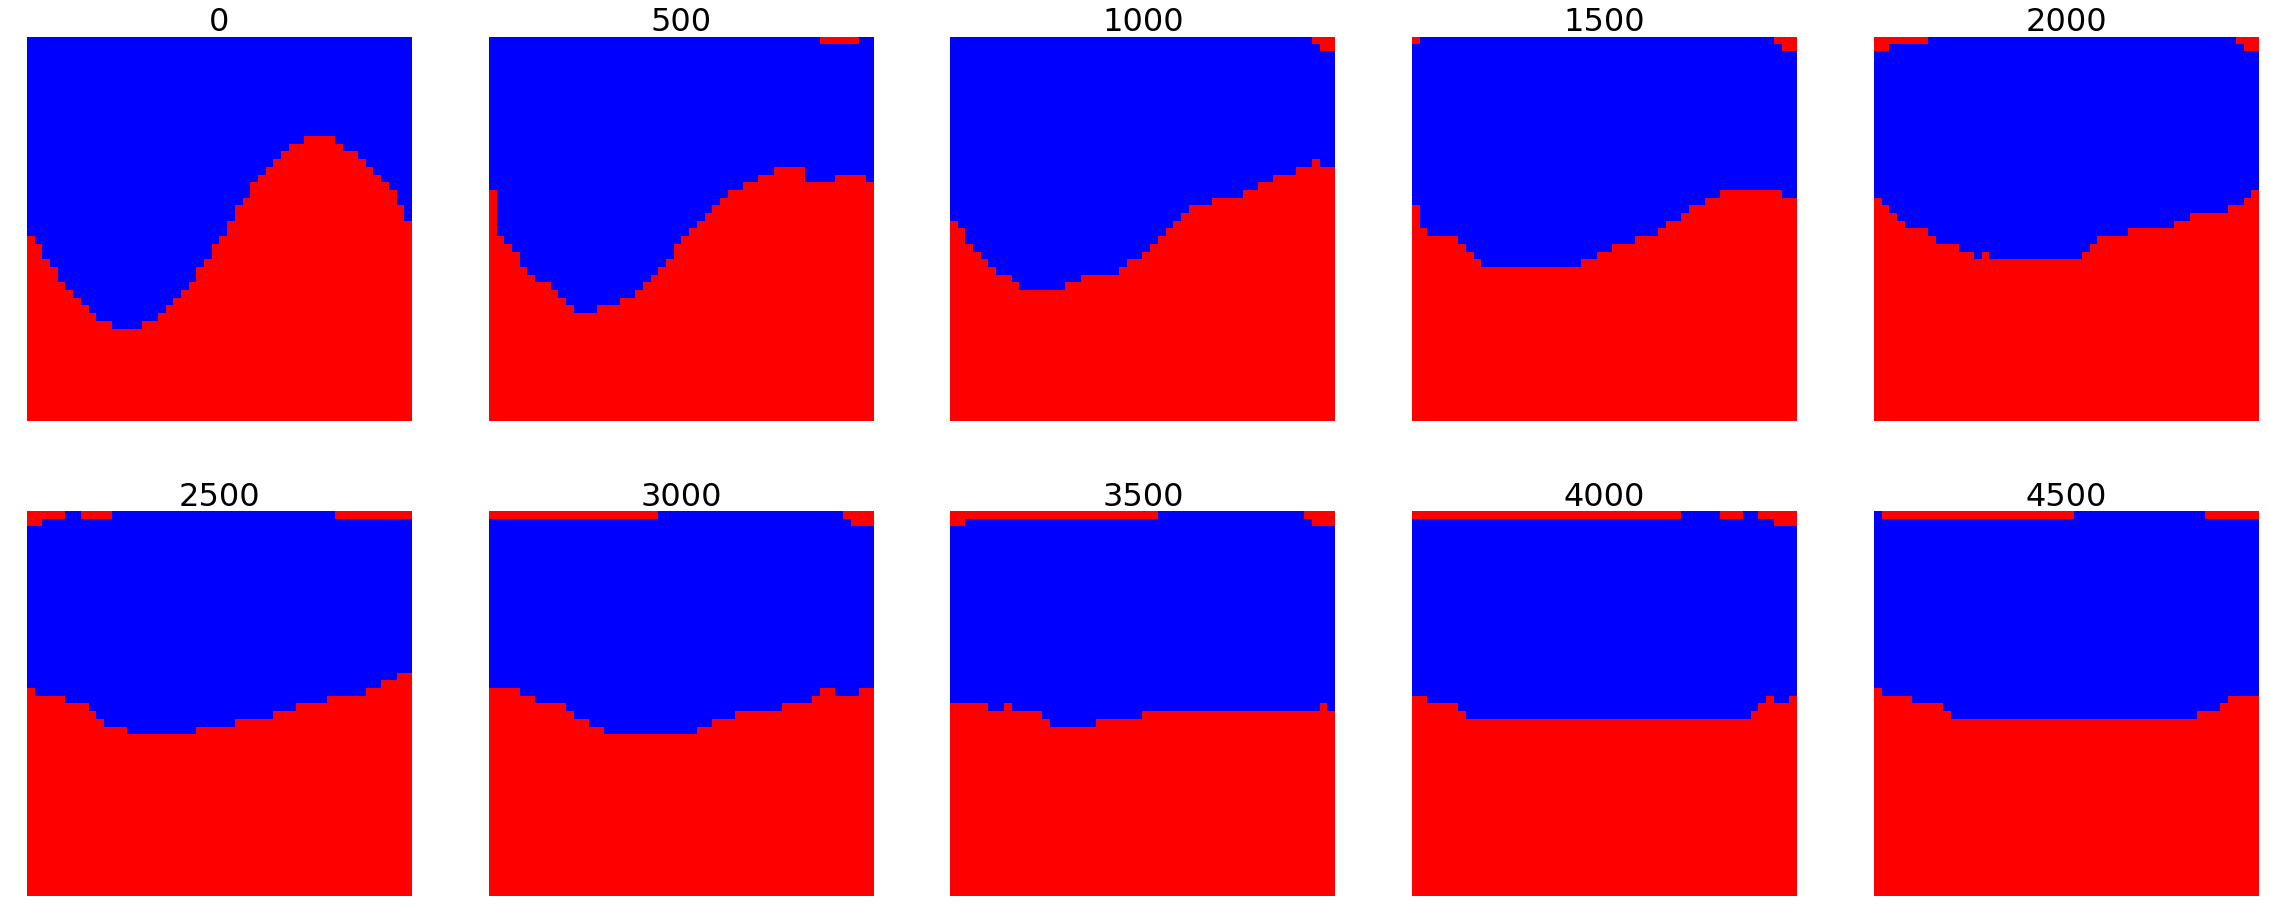

In [61]:
schelling(L=50,steps=[500*i for i in range(10)],
          initialconfig=sinconfig,empty=0.0,typefrac=0.5,amplitude=0.5,
          utility=stepfunction_nopbc,x=3/8,
          move=swap,d=50,liquid=True,
          save=True,name='swap_3')